In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
world_df: pl.DataFrame = pl.read_csv(
    "../data/raw/world-data-2023.csv", ignore_errors=True
)

# Now, we're going to convert this percentage column to float
world_df = world_df.with_columns(
    [
        pl.col("Forested Area (%)")
        .str.strip_chars()
        .str.replace_all("%", "")
        .cast(pl.Float64)
    ]
)

# Filter countries where 'Forested Area (%)' is null or empty
null_values = world_df.filter(
    world_df["Forested Area (%)"].is_null() | world_df["Forested Area (%)"].is_nan()
)

print(null_values.select(["Country", "Forested Area (%)"]))

shape: (7, 2)
┌────────────────────────────────┬───────────────────┐
│ Country                        ┆ Forested Area (%) │
│ ---                            ┆ ---               │
│ str                            ┆ f64               │
╞════════════════════════════════╪═══════════════════╡
│ Eswatini                       ┆ null              │
│ Vatican City                   ┆ null              │
│ Monaco                         ┆ null              │
│ Nauru                          ┆ null              │
│ North Macedonia                ┆ null              │
│ Palestinian National Authority ┆ null              │
│ South Sudan                    ┆ null              │
└────────────────────────────────┴───────────────────┘


In [3]:
forest_df: pl.DataFrame = pl.read_csv(
    "../data/raw/forest_area_percent.csv", ignore_errors=True
)

forest_df.head(5)

Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Afghanistan""","""AFG""",1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782
"""Albania""","""ALB""",28.788321,28.717153,28.645985,28.574818,28.50365,28.432482,28.361314,28.290146,28.218978,28.14781,28.076642,28.123248,28.169854,28.21646,28.263066,28.309672,28.356277,28.402883,28.449489,28.496095,28.542701,28.594653,28.646606,28.698558,28.750511,28.802464,28.80219,28.792062,28.791971,28.791971,28.791971,28.791971
"""Algeria""","""DZA""",0.699908,0.696214,0.692519,0.688824,0.685129,0.681435,0.67774,0.674045,0.67035,0.666655,0.662961,0.677194,0.691427,0.705661,0.719894,0.734127,0.74836,0.762594,0.776827,0.79106,0.805294,0.808485,0.811675,0.814866,0.818057,0.821248,0.821248,0.81579,0.810332,0.81411,0.818309,0.822228
"""American Samoa""","""ASM""",90.35,90.18,90.01,89.84,89.67,89.5,89.33,89.16,88.99,88.82,88.65,88.5,88.35,88.2,88.05,87.9,87.75,87.6,87.45,87.3,87.15,87.0,86.85,86.7,86.55,86.4,86.25,86.1,85.95,85.8,85.65,85.5
"""Andorra""","""AND""",34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553


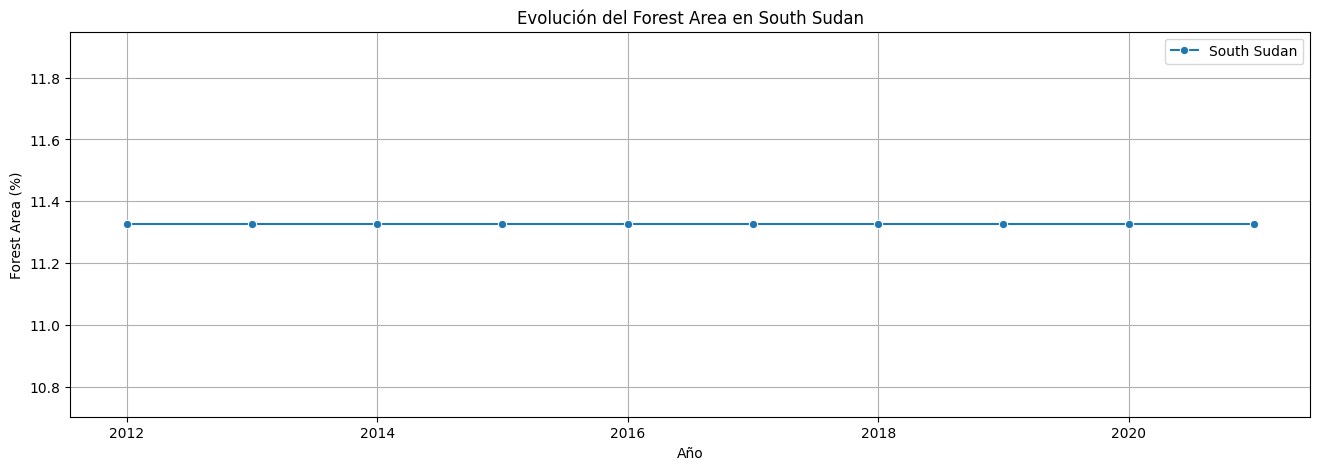

In [4]:
pais = "South Sudan"
years = [
    "1990",
    "1991",
    "1992",
    "1993",
    "1994",
    "1995",
    "1996",
    "1997",
    "1998",
    "1999",
    "2000",
    "2001",
    "2002",
    "2003",
    "2004",
    "2005",
    "2006",
    "2007",
    "2008",
    "2009",
    "2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
]
forest_area = forest_df.filter(forest_df["Country Name"] == pais).select(years).row(0)

years_np = [int(a) for a in years]
forest_area_np = list(forest_area)

# Visualization using matplotlib library
plt.figure(figsize=(16, 5))
sns.lineplot(x=years_np, y=forest_area_np, marker="o", label=pais)
plt.title(f"Evolución del Forest Area en {pais}")
plt.xlabel("Año")
plt.ylabel("Forest Area (%)")
plt.grid(True)
plt.show()

1. Eswatini sees an increase in its forest area consistently

2. North Macedonia has kept its forest area linear since 2016

3. South Sudan has maintained its forest area completely linearly

4. Vatican City, Monaco, Nauru and Palestinian National Authority do not appear in the csv

### Completing the Missing Data

To complete the missing cells, we will proceed as follows:

- For **Eswatini**, we can calculate the annual change rate and project it for 2023, applying the equation:

  $$ \text{Average change rate} = \frac{FA_{2021} - FA_{1990}}{2021 - 1990} $$

  $$ FA_{2023} = FA_{2021} \times (1 + \text{Average change rate})^2 $$

- For **North Macedonia** and **South Sudan**, we can use the forest area values recorded in 2021.

- Finally, for **Vatican City**, **Monaco**, and **Nauru**, we will manually fill in the cells by searching for these values for the year 2023.


In [5]:
# Firstly, we filter the country Eswatini
eswatini_df = forest_df.filter(pl.col("Country Name") == "Eswatini")

# Calculate the average change rate
tasa_cambio = (eswatini_df["2021"][0] - eswatini_df["1990"][0]) / (2021 - 1990)

# Extrapolate to 2023:
fa_2023 = eswatini_df["2021"][0] + 2 * tasa_cambio

print(eswatini_df)
print("Eswatini's Forest Area (2023): ", fa_2023)

shape: (1, 34)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Country   ┆ Country   ┆ 1990      ┆ 1991      ┆ … ┆ 2018      ┆ 2019      ┆ 2020      ┆ 2021     │
│ Name      ┆ Code      ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ ---       ┆ ---       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
│ str       ┆ str       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Eswatini  ┆ SWZ       ┆ 26.810465 ┆ 26.881047 ┆ … ┆ 28.787209 ┆ 28.857558 ┆ 28.927907 ┆ 28.99825 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘
Eswatini's Forest Area (2023):  29.13940359645161


In [6]:
# Now, we can update the value in the "Forest Area (%)" column of the world_df DataFrame
forested_column = [col for col in world_df.columns if "Forested" in col]

world_df = world_df.with_columns(
    pl.when(pl.col("Country") == "Eswatini")
    .then(round(fa_2023, 1))
    .otherwise(pl.col(forested_column))
    .alias("Forested Area (%)")
)

world_df[56:60].select(["Country", "Forested Area (%)"])

Country,Forested Area (%)
str,f64
"""Eswatini""",29.1
"""Ethiopia""",12.5
"""Fiji""",55.9
"""Finland""",73.1


As we have said before, for **North Macedonia** and **South Sudan**, we can use the forest area values recorded in 2021.

In [7]:
ls_countries = ["North Macedonia", "South Sudan"]

for country in ls_countries:
    world_df = world_df.with_columns(
        pl.when(pl.col("Country") == country)
        .then(round(forest_df.filter(pl.col("Country Name") == country)["2021"][0], 1))
        .otherwise(pl.col(forested_column))
        .alias("Forested Area (%)")
    )

world_df[128:130].select(["Country", "Forested Area (%)"])

Country,Forested Area (%)
str,f64
"""North Macedonia""",39.7
"""Norway""",33.2


In [8]:
world_df[163:165].select(["Country", "Forested Area (%)"])

Country,Forested Area (%)
str,f64
"""South Sudan""",11.3
"""Spain""",36.9


Finally, for **Vatican City**, **Monaco**, **Nauru** and **Palestinian National Authority**, we will manually fill in the cells by searching for these values for the year 2023.

- **Vatican City:** Given its small size (0.17 km²) and high density of buildings, no specific data is available regarding forest coverage in Vatican City. It is likely that forested areas are minimal or nonexistent.

- **Monaco:** Due to its limited land area (2 km²) and extremely high population density, Monaco lacks available space for forests. (infobae.com)

- **Nauru:** This Pacific island, covering an area of 21 km², has undergone significant environmental degradation due to phosphate mining, resulting in the complete absence of forested land.

In [17]:
ls_countries = ["Vatican City", "Monaco", "Nauru", "Palestinian National Authority"]

for i in range(0, len(ls_countries)):
    world_df = world_df.with_columns(
        pl.when(pl.col("Country") == ls_countries[i])
        .then(
            round(1.68, 1)
            if ls_countries[i] == "Palestinian National Authority"
            else 0.0
        )
        .otherwise(pl.col(forested_column))
        .alias("Forested Area (%)")
    )

Now, we are going to display the number of missing values in each column.

In [18]:
missing_values = world_df.select(
    pl.col("Forested Area (%)")
    .is_null()
    .sum()
    .alias("Forested Area (%) missing values")
)
missing_values

Forested Area (%) missing values
u32
0
